In [273]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


## READ IN DATA

In [274]:
svm_df = pd.read_csv('./data/svm.csv',header=None)
lda_df = pd.read_csv('./data/lda.csv', header=None)

In [275]:
svm_df.head()

,0,1,2,3,4
0,600.0,0.5,0.0100,0.27620,191.980
1,900.0,0.8,0.1000,0.27420,99.976
2,2000.0,5.0,0.1000,0.27910,114.410
3,5000.0,1.0,0.0001,0.25770,748.726
4,1.0,5.0,0.0001,0.28714,1048.862


In [276]:
lda_df.head()

,0,1,2,3,4
0,1.0,4.0,16.0,2014.255351,36393.19
1,0.9,1024.0,4096.0,1680.540179,36419.51
2,0.6,1024.0,4096.0,1328.191297,24219.85
3,0.6,16.0,4.0,2859.440420,18862.01
4,0.7,1.0,4096.0,1313.263743,11218.42


## VISULAISE DATA

#### Make a heatmap of the value of the Goldstein–Price function over the domain X= [−2,2] × [−2,2] using a dense grid of values, with 1000 values per dimension, forming a 1000 ×1000 image.

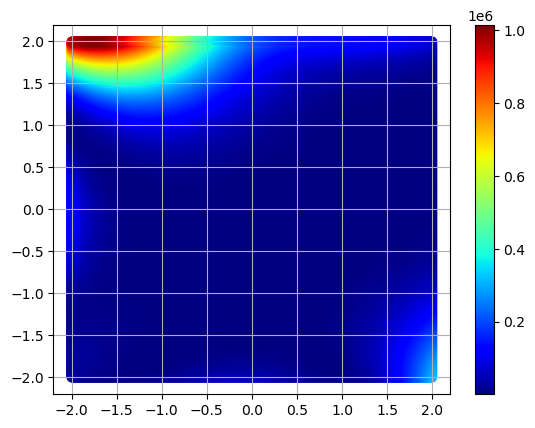

In [287]:
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x, y)

Z = (1+(x+y+1)**2*(19-14*x+3*x**2-14*y+6*x*y+3*y**2))*(30+(2*x-3*y)**2*(18-32*x+12*x**2+48*y-36*x*y+27*y**2))  

plt.scatter(x, y, c=Z, cmap='jet',vmin=Z.min(), vmax=Z.max())
plt.colorbar()
plt.grid()
plt.show()

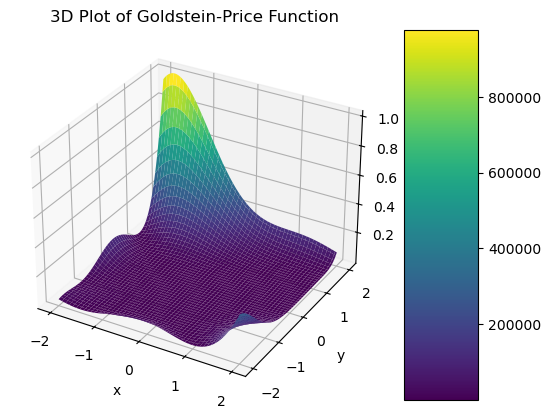

In [288]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def goldstein_price(x, y):
    u = 1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)
    v = 30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2)
    return u * v

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

Z = goldstein_price(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(X, Y, Z, cmap='viridis')


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('3D Plot of Goldstein-Price Function')


fig.colorbar(surf, aspect=5)

plt.show()

In [289]:
ax

<Axes3D: title={'center': '3D Plot of Goldstein-Price Function'}, xlabel='x', ylabel='y'>

#### Describe the behavior of the function. Does it appear stationary? (That is, does the behavior of the function appear to be relatively constant throughout the domain?)

#### Can you find a transformation of the data that makes it more stationary?

#### Make a kernel density estimate of the distribution of the values for the lda and svm bench- marks. Interpret the distributions.

<Figure size 640x480 with 0 Axes>

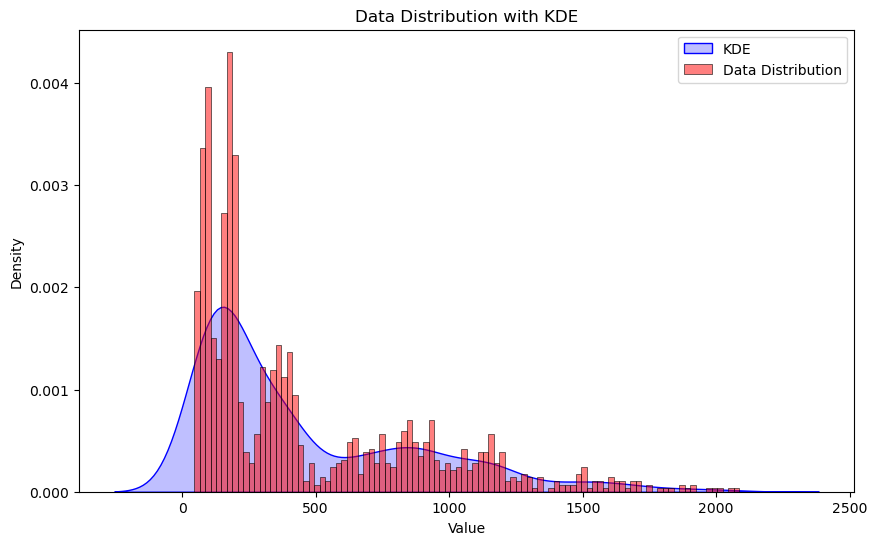

In [290]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

plt.figure("HISTOGRAM_SVM")


data = svm_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

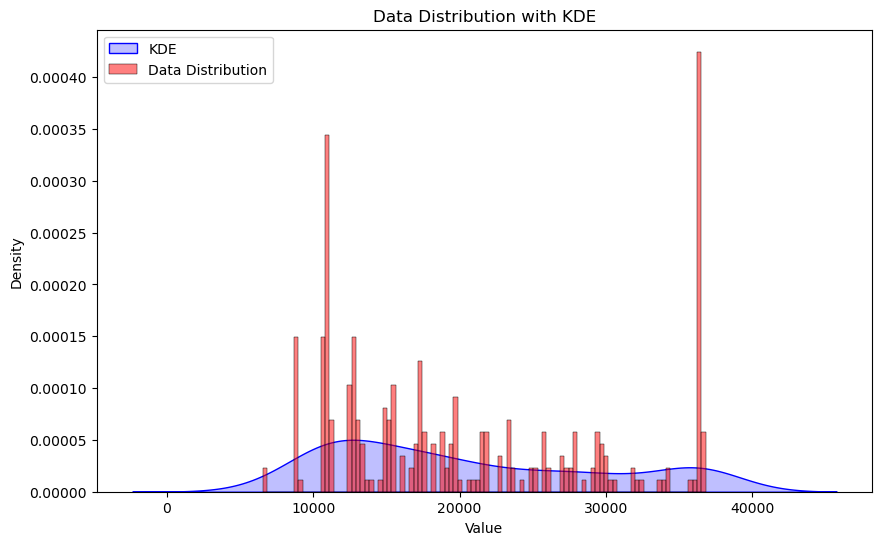

In [291]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

plt.figure("HISTOGRAM_LDA")


data = lda_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


#### Again, can you find a transformation that makes the performance better behaved?

## Model fitting

#### Select a set of 32 training points for the Goldstein–Price function in the domain X= [−2,2] ×[−2,2] using a Sobol sequence. This is a so-called low-discrepancy sequence that produces “quasirandom” points that fill the space relatively evenly; see the Wikipedia article for more information, and note that this should be built into most scientific software. Measure the function at these locations to form a dataset D.

In [102]:
from scipy.stats import qmc
domain = [-2, 2]
sampler = qmc.Sobol(d=2, scramble=True)
samples = sampler.random_base2(m=5)
scaled_samples = domain[0] + (domain[1] - domain[0]) * samples
x,y = scaled_samples[:,0], scaled_samples[:,1]
X_train = scaled_samples
X = np.linspace(0, len(X_train)-1, len(X_train))
Y_train = (1+(x+y+1)**2*(19-14*x+3*x**2-14*y+6*x*y+3*y**2))*(30+(2*x-3*y)**2*(18-32*x+12*x**2+48*y-36*x*y+27*y**2))  
Y_train.mean()

43245.43634030469

#### Fit a Gaussian process model to the data using a constant mean and a squared exponential covariance. As the output of a deterministic computer program, there is no “noise” in our observations, so we should fix the standard deviation of the noise to a small value such as 0.001. This is possible in most gp software packages. Maximize the marginal likelihood of the data as a function of the hyperparameters: constant mean value and the length scale and output scale of the covariance function.

In [526]:
import pymc as pm
import math
with pm.Model() as model:
      mean_const = pm.Normal("mean_const", mu=0, sigma=5)
      length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
      output_scale = pm.HalfNormal("output_scale", sigma=1)
      
      cov_func = output_scale**2 * pm.gp.cov.ExpQuad(2, ls=length_scale)
      
      gp = pm.gp.Marginal(mean_func=pm.gp.mean.Constant(mean_const), cov_func=cov_func)
      sigma_n = 1
      y_dist = gp.marginal_likelihood("y_dist", X=X_train, y=Y_train, sigma=sigma_n)

      map_estimate = pm.find_MAP()

      # Step 4: Sample from the posterior for predictions
      trace = pm.sample(1000, tune=1000, return_inferencedata=True)



Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_const, length_scale, output_scale]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Make a heatmap of the Gaussian process posterior mean as you did of the function. Compare the predicted values with the true values. Do you see systematic errors?

/var/folders/2v/9rjk2f_n3pgd38k9vyj_8_tw0000gn/T/ipykernel_71331/2608877301.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_train[:,0], X_train[:,1],Y_train, cmap='viridis' ,label = 'data points')


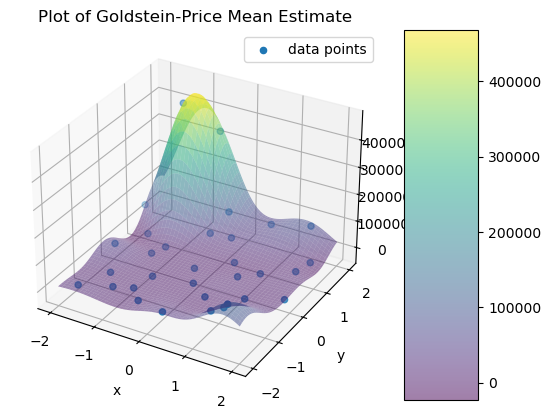

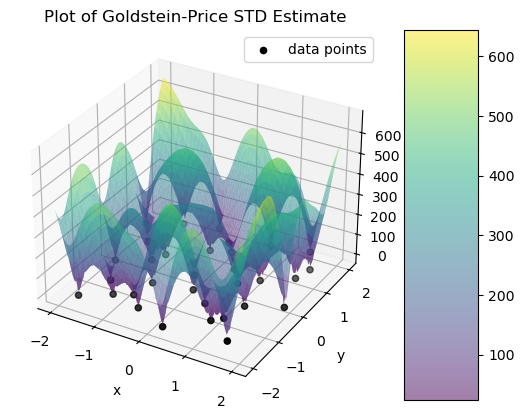

In [286]:
x1_range = np.linspace(-2, 2, 100)
x2_range = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_pred = np.column_stack([X1.ravel(), X2.ravel()])

with model:
    mu, var = gp.predict(X_pred, point=map_estimate, diag=True)
    std = np.sqrt(var)

##MEAN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, mu.reshape((len(X1), len(X2))), cmap='viridis', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],Y_train, cmap='viridis' ,label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.title('Plot of Goldstein-Price Mean Estimate')


fig.colorbar(surf, aspect=5)

plt.show()

##STD

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, std.reshape((len(X1), len(X2))), cmap='viridis', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],0, color = 'black', label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.title('Plot of Goldstein-Price STD Estimate')


fig.colorbar(surf, aspect=5)

plt.show()







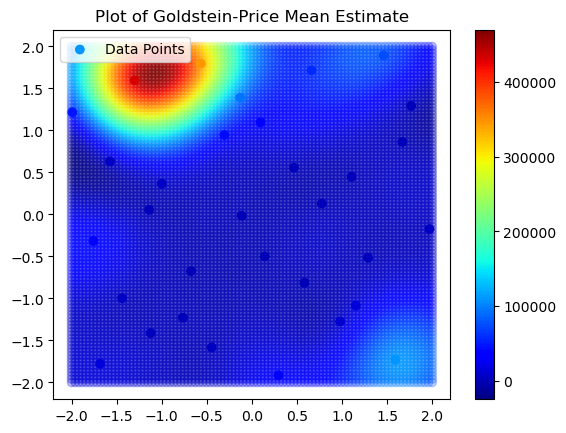

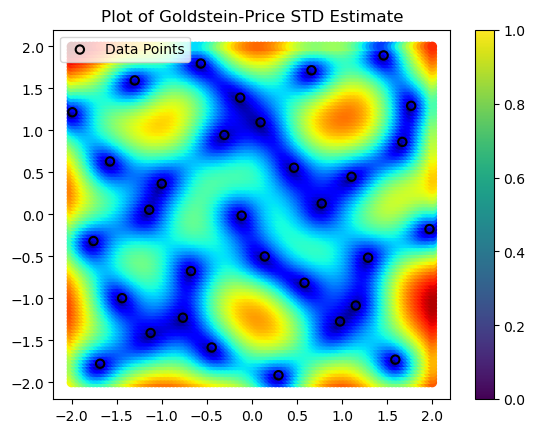

In [330]:
from matplotlib.markers import MarkerStyle


x1_range = np.linspace(-2, 2, 100)
x2_range = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_pred = np.column_stack([X1.ravel(), X2.ravel()])

with model:
    mu, var = gp.predict(X_pred, point=map_estimate, diag=True)
    std = np.sqrt(var)

##MEAN

fig = plt.figure()
plt.title('Plot of Goldstein-Price Mean Estimate')

plt.scatter(X1, X2, c=mu, cmap='jet',vmin=mu.min(), vmax=mu.max(), alpha = 0.25)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='jet',vmin=mu.min(), vmax=mu.max(), label = 'Data Points')
plt.colorbar()
plt.legend()
plt.show()


fig2 = plt.figure()
plt.title('Plot of Goldstein-Price STD Estimate')
plt.scatter(X1, X2, c=std, cmap='jet',vmin=std.min(), vmax=std.max(), alpha = 1)
plt.scatter(X_train[:,0], X_train[:,1], color='black', label = 'Data Points', marker= MarkerStyle('o', fillstyle = 'none')  )
plt.colorbar()
plt.legend()
plt.show()











#### BIC

In [ ]:
BIC = 3*math.log(len(X_train)) - 2* y_dist.eval().mean()
f"BIC: {BIC}"

'BIC: 8.492088765818897'

#### BEST BIC (Compositional Kernel Grammar )

In [ ]:
import pymc as pm
import pytensor.tensor as pt


def fit_gp_model(X, y, mean_func, kernel_func, model_name=""):
      with pm.Model() as model:

            if mean_func == "constant":
                  m = pm.Normal(f"m{model_name}", 0, 5)
                  mean = pm.gp.mean.Constant(m)
            elif mean_func == "linear":
                  a1 = pm.Normal(f"a1{model_name}", 0, 5)
                  a2 = pm.Normal(f"a2{model_name}", 0, 5)
                  b = pm.Normal(f"b{model_name}", 0, 5)
                  mean = pm.gp.mean.Linear([a1,a2],b) 
            else:
                  raise ValueError("Unsupported Mean Functio")

            length = pm.Gamma(f"ℓ{model_name}", alpha=2, beta=1)
            output_scale = pm.HalfCauchy(f"η{model_name}", beta=1)
            
            if kernel_func == "RBF":
                  cov = output_scale**2 * pm.gp.cov.ExpQuad(2, ls=length)
            elif kernel_func == "Matern32":
                  cov = output_scale**2 * pm.gp.cov.Matern32(2, ls=length)
            elif kernel_func == "Matern52":
                  cov = output_scale**2 * pm.gp.cov.Matern52(2, ls=length)
            elif kernel_func == "Periodic":
                  p = pm.Gamma(f"p{model_name}", alpha=2, beta=1)
                  cov = output_scale**0.5 * pm.gp.cov.Periodic(2, ls=length, period=p)
            else:
                  raise ValueError("Unsupported kernel")

            σ = 0.001
            gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)
            y_obs = gp.marginal_likelihood(f"y_obs{model_name}", X=X, y=y, sigma=σ)
            

            trace = pm.sample(progressbar=False)
            pm.compute_log_likelihood(trace)
            
      bic = 3*math.log(len(X_train)) - 2* y_obs.eval().mean()

      return bic, trace


mean_functions = ["constant", "linear"]
kernel_functions = ["RBF", "Matern32", "Matern52"]

best_bic = float('inf')
best_model = None


for mean_func in mean_functions:
    for kernel_func in kernel_functions:
        bic, trace = fit_gp_model(X_train, Y_train, mean_func, kernel_func, model_name=f"_{mean_func}_{kernel_func}")
        print(f"Model: Mean={mean_func}, Kernel={kernel_func}, BIC={bic:.2f}")
        

        if bic < best_bic:
            best_bic = bic
            best_model = (mean_func, kernel_func)

print(f"\nBest Model: Mean={best_model[0]}, Kernel={best_model[1]}, BIC={best_bic:.2f}")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_constant_RBF, ℓ_constant_RBF, η_constant_RBF]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Output()

Model: Mean=constant, Kernel=RBF, BIC=3.83


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [543]:
3*math.log(len(X_train)) - 2* y_obs.eval().mean()

17.641203294210296

In [542]:
y_obs.eval().mean()

-3.6219977929055585